#### https://wikidocs.net/44249
#### 따라해보는 것을 과제로 선택

# 네이버 영화 리뷰 감성 분류하기
## 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [1]:
# 사용하기 전에! 
# tensorflow, konlpy 등 install 해두어야 한다.
# Java도 미리 받아두어야 한다.
# https://machine-geon.tistory.com/42
# https://rural-mouse.tistory.com/5
# 블로그 참고하여 설정 한 후에 다시 jupyter 를 실행시켜야한다.

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
# pad_sequences 일정한 길이로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 01. 데이터 로드하기

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print(train_data.shape)
print(train_data.head(3))

print()

print(test_data.shape)
print(test_data.head(3))

(150000, 3)
         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0

(50000, 3)
        id                                document  label
0  6270596                                     굳 ㅋ      1
1  9274899                    GDNTOPCLASSINTHECLUB      0
2  8544678  뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0


#### 02. 데이터 전처리

In [3]:
# nunique() : 유니크한 value의 수를 나타낸다.
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [4]:
# 3,818개의 중복되는 데이터가 발견되기 때문에 중복되는 결과 삭제
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.shape

(146183, 3)

   label  count
0      0  73342
1      1  72841


<AxesSubplot:>

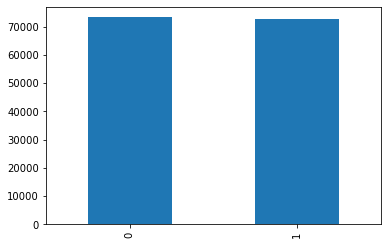

In [5]:
# 긍정과 부정의 샘플 갯수 확인
print(train_data.groupby('label').size().reset_index(name='count'))
train_data['label'].value_counts().plot(kind = 'bar')

In [6]:
# Null 값 확인
print(train_data.isnull().sum())

# Null 값 삭제
train_data = train_data.dropna(how='any')

# 다시 Null 값 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64


id          0
document    0
label       0
dtype: int64

In [7]:
# 정규표현식을 사용하여 한글을 제외한 문자들 삭제
print(train_data.head(3))
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head(3)

         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [8]:
# 공백 변경
train_data['document'].replace('', np.nan, inplace=True)

# Null 값 확인
print(train_data.isnull().sum())

# Null 값 삭제
train_data = train_data.dropna(how='any')
train_data.isnull().sum()

id            0
document    391
label         0
dtype: int64


id          0
document    0
label       0
dtype: int64

In [9]:
# Test 항목에도 똑같이 진행
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


#### 03. 토큰화 :  불용어(조사, 접속사 등) 제거

In [10]:
# 불용어 정의
stopwords = ['의', '가', '이', '은', '들', 
             '는', '좀', '잘', '걍', '과', 
             '도', '를', '으', '로', '자', 
             '에', '와', '한', '하다']

# 토큰화를 위한 형태소 분석기는 KoNLPy Okt 사용
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [12]:
# 불용어를 제외하고 X_train에 저장한다.
# 시간이 꽤 걸린다.

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [13]:
# X_test도 동일하게 진행한다.
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

#### 04. 정수 인코딩

In [14]:
# 훈련 데이터에 대해서 단어 집합을 만들어야 한다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '으로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, '오다': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '개': 101, '하': 

In [15]:
# 3회 미만의 단어들이 이 데이터에서 얼만큼의 비중을 차지하는 지 확인해보자.
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43751
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62615711640877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8717147610743852


In [16]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [18]:
# 단어의 집합의 크기는 19416개이다.
# 이것을 케라스 토크나이저의 인자로 넘겨주면, 
# 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다.
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train[:3]

[[51, 455, 17, 261, 660],
 [934, 458, 42, 603, 2, 215, 1449, 25, 962, 676, 20],
 [387, 2444, 1, 2315, 5671, 3, 223, 10]]

In [20]:
# train_data에서 y_train과 y_test 별도로 저장해준다
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

#### 05. 빈 샘플 제거

In [21]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145377
145377


#### 06. 패딩

리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 11.001664637459847


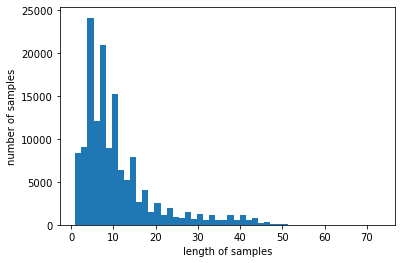

In [22]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율 : {(cnt/len(nested_list))*100}")
    
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율 : 94.08434621707697


In [24]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [25]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
#model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         1941600   
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [103]:
# COMPILE 할 때 조기 종료 조건 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# COMPILE 할 때 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [104]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3912 - acc: 0.8224
Epoch 00001: val_acc improved from -inf to 0.84145, saving model to best_model.h5
1939/1939 [==============================] - 37s 19ms/step - loss: 0.3912 - acc: 0.8224 - val_loss: 0.3544 - val_acc: 0.8414
Epoch 2/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3292 - acc: 0.8562
Epoch 00002: val_acc improved from 0.84145 to 0.85187, saving model to best_model.h5
1939/1939 [==============================] - 35s 18ms/step - loss: 0.3291 - acc: 0.8562 - val_loss: 0.3437 - val_acc: 0.8519
Epoch 3/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3046 - acc: 0.8699
Epoch 00003: val_acc improved from 0.85187 to 0.85896, saving model to best_model.h5
1939/1939 [==============================] - 36s 18ms/step - loss: 0.3046 - acc: 0.8699 - val_loss: 0.3282 - val_acc: 0.8590
Epoch 4/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2860 - acc: 0.8800
E

In [105]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 7s 4ms/step - loss: 0.3355 - acc: 0.8555

 테스트 정확도: 0.8555


## 3. 리뷰 예측해보기

In [116]:
def sentiment_predict(new_sentence):
    new_s = okt.morphs(new_sentence, stem=True)
    new_s = [w for w in new_s if not w in stopwords]
    
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    result = loaded_model.predict(pad_new)
    return f"{round(float(result), 2)*100}% " + ("긍정"if result >= 0.5 else "부정") + "리뷰"

In [117]:
sentiment_predict("꿀잼")

'97.0% 긍정리뷰'

In [118]:
sentiment_predict("지루해요.")

'43.0% 부정리뷰'